# Stokes Benchmark SolCx

In [1]:
# options = PETSc.Options()
# options["help"] = None

In [3]:
import petsc4py
from petsc4py import PETSc
import pickle

In [31]:
import underworld3 as uw
import os
from underworld3.systems import Stokes
from underworld3 import function
import numpy as np

import sympy
from sympy import Piecewise

import matplotlib.pyplot as plt

In [6]:
def plotFig(mesh, v, p, v_proj):
    import numpy as np
    import pyvista as pv
    import vtk

    pv.global_theme.background = "white"
    pv.global_theme.window_size = [750, 1200]
    pv.global_theme.antialiasing = True
    pv.global_theme.jupyter_backend = "panel"
    pv.global_theme.smooth_shading = True

    mesh.vtk("tmp_mesh.vtk")
    pvmesh = pv.read("tmp_mesh.vtk")

    # pvmesh.point_data["V"] = uw.function.evaluate(v.sym, mesh.data)
#     # with mesh.access(v):
#     for i in mesh.dim:
#         v_projection = uw.systems.Projection(mesh, v_proj)
#         v_projection.uw_function = v.sym[i]
#         v_projection.smoothing = 1.0e-3
#         v_projection.solve(_force_setup=True)
#         with mesh.access(v_proj):
#             pvmesh.point_data[f"V{i}"] = v_proj
            
#     vel = 
    
#         pvmesh.point_data["V"] = v_proj.dot(v_proj)

    arrow_loc = np.zeros((mesh._centroids.shape[0], 3))
    arrow_loc[:, 0:2] = mesh._centroids[...]

    arrow_length = np.zeros((mesh._centroids.shape[0], 3))
    arrow_length[:, 0] = uw.function.evaluate(v.sym[0], mesh._centroids)
    arrow_length[:, 1] = uw.function.evaluate(v.sym[1], mesh._centroids)

    pl = pv.Plotter(window_size=[1000, 1000])
    pl.add_axes()

    pl.add_mesh(
        pvmesh,
        cmap="coolwarm",
        edge_color="Black",
        show_edges=True,
        # scalars="V",
        use_transparency=False,
        opacity=1.0,
    )

    pl.add_arrows(arrow_loc, arrow_length, mag=3)

    pl.show(cpos="xy")

In [7]:
def solCx_model(n_els, penalty, weak_BC=True, viscosity=[1e6,1], qdeg = 3, hwNum = None):
    
    # mesh = uw.meshing.UnstructuredSimplexBox(
    #                                         minCoords=(0.0, 0.0), maxCoords=(1.0, 1.0), cellSize=1 / n_els, qdegree=2
    #                                         )
    
    mesh = uw.meshing.StructuredQuadBox(
                                        minCoords=(0.0, 0.0), 
                                        maxCoords=(1.0, 1.0),
                                        elementRes=(n_els, n_els), 
                                        #qdegree = qdeg
                                        )
    
    
    v = uw.discretisation.MeshVariable("U", mesh, mesh.dim, degree=2)
    v_proj = uw.discretisation.MeshVariable("v", mesh, 1, degree=2)
    p = uw.discretisation.MeshVariable("P", mesh, 1, degree=1)
    
    
    x, y = mesh.CoordinateSystem.X
    
    stokes = uw.systems.Stokes(mesh, velocityField=v, pressureField=p)
    stokes.constitutive_model = uw.systems.constitutive_models.ViscousFlowModel(mesh.dim)
    
    stokes.bodyforce = sympy.Matrix(
                                    [0, sympy.cos(sympy.pi * x) * sympy.sin(sympy.pi * y)]
                                    )
    if weak_BC == True:
        # res = 1 / n_els
        # hw = 1000 / res
        # sdev = np.sqrt(1/(2*hw)) # using original method
        
        hw = hwNum
        print(hw)
        sdev = hw/2.355
        print(sdev)
        # surface_fn = sympy.exp(-((y - 1.0) ** 2) * hw)
        # base_fn = sympy.exp(-(y**2) * hw)
        # right_fn = sympy.exp(-((x - 1.0) ** 2) * hw)
        # left_fn = sympy.exp(-(x**2) * hw)
        surface_fn = sympy.exp(-((y - 1.0) ** 2)/(2*sdev**2))
        base_fn = sympy.exp(-(y**2)/(2*sdev**2))
        right_fn = sympy.exp(-((x - 1.0) ** 2)/(2*sdev**2))
        left_fn = sympy.exp(-(x**2)/(2*sdev**2))
        
        # penalty = 100*(1/mesh.get_min_radius()**2)
        
        # penalty = 1.0e6 #325 * (1/(mesh.get_min_radius()**2))

        stokes.bodyforce[0] -= penalty * v.sym[0] * (left_fn + right_fn)
        stokes.bodyforce[1] -= penalty * v.sym[1] * (surface_fn + base_fn)
        
    else:
        stokes.add_dirichlet_bc(
            (0.0, 0.0), ["Top", "Bottom"], 1)  # top/bottom: components, function, markers
        stokes.add_dirichlet_bc(
            (0.0, 0.0), ["Left", "Right"], 0)  # left/right: components, function, markers
        

    x_c = 0.5
    
    viscosity_fn = sympy.Piecewise(
        (viscosity[0], x > x_c),
        (viscosity[1], True)               )
    
    
    stokes.constitutive_model.Parameters.viscosity = viscosity_fn
    stokes.saddle_preconditioner = 1 / stokes.constitutive_model.Parameters.viscosity


    stokes.solve(zero_init_guess=True)
    
    # if uw.mpi.size == 1:
    #     plotFig(mesh=mesh, v=v, p=p, v_proj=v_proj)
        
    volume_int = uw.maths.Integral(mesh, 1.0)
    volume = volume_int.evaluate()
    v_dot_v_int = uw.maths.Integral(mesh, stokes.u.fn.dot(stokes.u.fn))
        
    def vrms():
        import math

        v_dot_v = v_dot_v_int.evaluate()
        return math.sqrt(v_dot_v / volume)
    
    return vrms()
        

In [ ]:
# sdev = np.sqrt(1/(2*hw))

In [39]:
# n_els = 16
# res = 1 / n_els
# hw = 1000 / res
# print(hw)

# y = np.arange(0, 1 + res, res)
# out_og = np.exp(-((y - 1.0) ** 2) * hw)

# sdev = np.sqrt(1/(2*hw))
# print("fwhm: ", sdev*2.355)
# out2 = np.exp(-((y - 1.0) ** 2)/(2*sdev**2))

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(dpi = 100)
# #ax.plot(y, out, "-o")
# ax.plot(y, out_og, "o")
# ax.plot(y, out2, "-")

0.005590169943749474


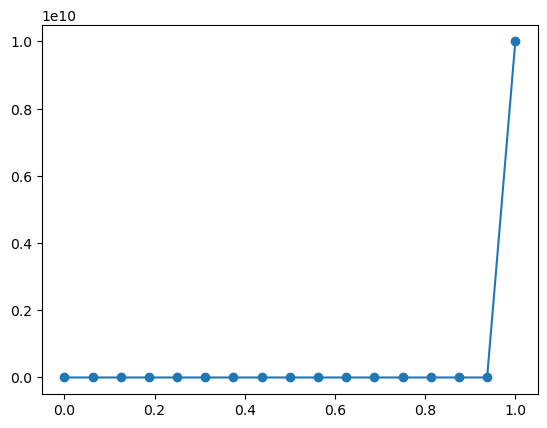

In [32]:
# # original formulation

# n_els = 16
# res = 1 / n_els

# # set separately
# hw = 0.006
# sdev = hw/2.355
# y = np.arange(0, 1 + res, res)
# out = np.exp(-((y - 1.0) ** 2)/(2*sdev**2))


# hw_og = 1000 / res
# print(np.sqrt(1/(2*hw_og)))
# out_og = np.exp(-((y - 1.0) ** 2) * hw_og)

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(dpi = 100)
# #ax.plot(y, out, "-o")
# ax.plot(y, 1e10*out_og, "-o")

In [33]:

# penalties = np.arange(2.9e10, 2.95e10+1e6, 0.01e10)
# penalties

array([2.90e+10, 2.91e+10, 2.92e+10, 2.93e+10, 2.94e+10, 2.95e+10])

In [23]:
qdeg = 2
ptf = 1e6 # 1e6, 1e7, 1e8, 1e9, 1e10
outdir = "/Users/jgra0019/Documents/codes/uw3-dev/penalty-method-testing/out"

if uw.mpi.rank == 0:
    if not os.path.exists(outdir):
        os.makedirs(outdir)

NameError: name 'os' is not defined

In [9]:

fwhm_arr = np.array([0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1])
res_arr = np.array([16, 32, 48, 64, 80, 96, 112, 128, 256])
#penalties = np.arange(2.9e10, 2.95e10+1e6, 0.01e10)

all_err = np.zeros([fwhm_arr.shape[0], res_arr.shape[0]])

for i, res in enumerate(res_arr): # loop through all the resolutions
    
    rel_error = []

    FSS = solCx_model(n_els = res, penalty = 0, weak_BC = False, qdeg = qdeg, hwNum = None)
    
    for fwhm in fwhm_arr: # loop through all the fwhm 

        vrms = solCx_model(n_els = res, penalty = ptf, weak_BC = True, qdeg = qdeg, hwNum = fwhm)

        relative_error = ((vrms - FSS)/FSS) * 100
        rel_error.append(relative_error)
        print(f"res: {res}, fwhm: {fwhm}, relative error: {relative_error}")

    all_err[:, i] = rel_error
    
# # ### closest value when n_els = 16
# # penalty = 2.91e10, ~0.0071% difference in v_rms

  0 SNES Function norm 0.0172385 
  1 SNES Function norm 6.54932e-06 
  2 SNES Function norm 1.16845e-09 
Nonlinear Stokes_1_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
0.001
0.0004246284501061571
  0 SNES Function norm 0.0172385 
Nonlinear Stokes_2_ solve did not converge due to DIVERGED_LINEAR_SOLVE iterations 0
res: 16, fwhm: 0.001, relative error: -100.0
0.003
0.0012738853503184713
  0 SNES Function norm 0.0172385 
  1 SNES Function norm 0.000274972 
  2 SNES Function norm 1.8022e-05 
  3 SNES Function norm 4.54842e-07 
Nonlinear Stokes_3_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
res: 16, fwhm: 0.003, relative error: 3142778.524517511
0.005
0.0021231422505307855
  0 SNES Function norm 0.0172385 
  1 SNES Function norm 0.000978205 
  2 SNES Function norm 3.031e-10 
Nonlinear Stokes_4_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
res: 16, fwhm: 0.005, relative error: 312.6114222989424
0.007
0.0029723991507431
  0 SNES Function nor

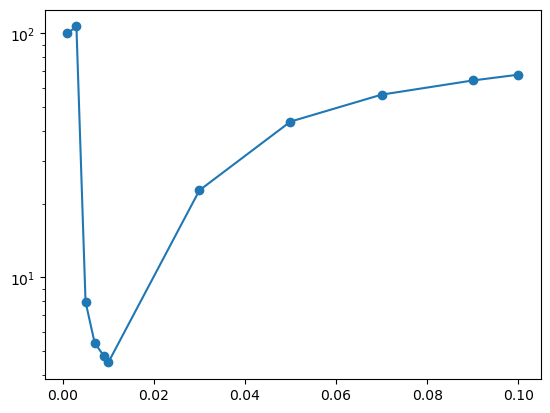

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi = 100)
ax.plot(fwhm_arr, np.abs(all_err[:, 1]), "-o")
ax.set_yscale("log")

In [25]:
with open(outdir + f"/qdeg{qdeg}_ptf{ptf:.1e}.pkl", "wb") as f:
    pickle.dump([all_err], f)

In [26]:
with open(outdir + f"/qdeg{qdeg}_ptf{ptf:.1e}.pkl", "rb") as f:
        data = pickle.load(f)

In [30]:
data[0].shape

(11, 9)

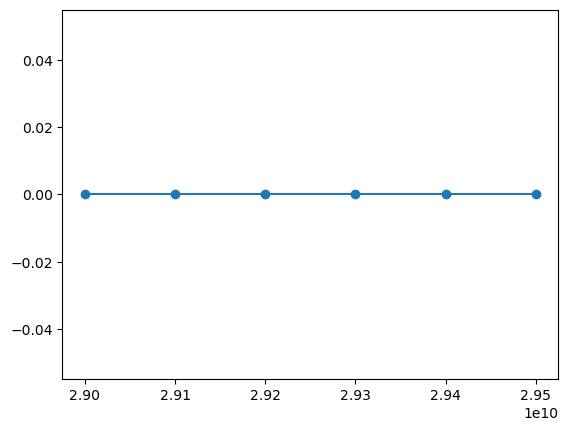

In [45]:
# fig, ax = plt.subplots(dpi = 100)
# #ax.plot(penalties_og, np.abs(rel_error_og), "o-")
# ax.plot(penalties_og, np.abs(rel_error_og) - np.abs(rel_error), "o-")
# #ax.set_xscale("log")

In [8]:
# FSS_32 = solCx_model(n_els=32, weak_BC=False, penalty = 0, viscosity=[1,1e3])

# # penalties = np.arange(4.5e7, 5e7+1e5, 1e6)


# # penalty_vrms_32 = []

# # for penalty in penalties:
# #     penalty_vrms_32.append( solCx_model(n_els=32, weak_BC=True, penalty=penalty) )
    
# # # ### closest value when n_els = 32   
# # # penalty = 4.6e7, ~0.007% difference in v_rms

# penalty = 4.6e7

# FSW_32 = solCx_model(n_els=32, weak_BC=True, penalty=penalty, viscosity=[1,1e3])

# relative_error = ((FSW_32 - FSS_32) / FSS_32) * 100
# relative_error

# # for vrms in penalty_vrms_32:
# #     relative_error = ((vrms - FSS_32) / FSS_32) * 100
# #     print(relative_error)

  0 SNES Function norm 0.00865169 
  1 SNES Function norm 8.27981e-06 
  2 SNES Function norm 1.736e-10 
Nonlinear Stokes_8_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
  0 SNES Function norm 0.00865169 
  1 SNES Function norm 7.45223e-08 
Nonlinear Stokes_9_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1


-0.03973991125093271

In [9]:
# FSS_64 = solCx_model(n_els=64, weak_BC=False, penalty = 0)

# penalties = np.arange(5e6, 5.5e6+1e5, 1e5)


# penalty_vrms_64 = []

# for penalty in penalties:
#     penalty_vrms_64.append( solCx_model(n_els=64, weak_BC=True, penalty=penalty) )
    
# ### closest value when n_els = 64    
# ### penalty = 5.3e6, ~0.0012% difference in v_rms


# for vrms in penalty_vrms_64:
#     relative_error = ((vrms - FSS_64) / FSS_64) * 100
#     print(relative_error)

  0 SNES Function norm 0.00433328 
  1 SNES Function norm 0.000329438 
  2 SNES Function norm 4.97114e-09 
Nonlinear Stokes_10_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
  0 SNES Function norm 0.00433328 
  1 SNES Function norm 5.68574e-05 
  2 SNES Function norm < 1.e-11
Nonlinear Stokes_11_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
  0 SNES Function norm 0.00433328 
  1 SNES Function norm 5.77603e-05 
  2 SNES Function norm < 1.e-11
Nonlinear Stokes_12_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
  0 SNES Function norm 0.00433328 
  1 SNES Function norm 5.84273e-05 
  2 SNES Function norm 6.182e-11 
Nonlinear Stokes_13_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
  0 SNES Function norm 0.00433328 
  1 SNES Function norm 6.23952e-05 
  2 SNES Function norm 3.799e-11 
Nonlinear Stokes_14_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2
  0 SNES Function norm 0.00433328 
  1 SNES Function norm 2.94957e-

In [ ]:
# penalties

In [ ]:
# # FSS_96 = solCx_model(n_els=96, weak_BC=False, penalty = 0)

# penalties = np.arange(4.93e6, 4.98e6, 1e4)


# penalty_vrms_96 = []

# for penalty in penalties:
#     penalty_vrms_96.append( solCx_model(n_els=96, weak_BC=True, penalty=penalty) )
    
# ### closest value when n_els = 96   
# ### penalty = 4.95e6, ~5.952858458274693e-05% difference in v_rms


# for vrms in penalty_vrms_96:
#     relative_error = ((vrms - FSS_96) / FSS_96) * 100
#     print(relative_error)

In [ ]:
# n_els= 96

# mesh = uw.meshing.StructuredQuadBox(
#                                         minCoords=(0.0, 0.0), maxCoords=(1.0, 1.0),elementRes=(n_els, n_els)
#                                         )

# mesh.get_min_radius()

In [ ]:
# import numpy as np

# penalties = np.array([2.91e10, 4.6e7, 5.3e6, 4.95e6 ])
# elementRes = np.array([16, 32, 64, 96])
# mesh_min_res = np.array([0.0312499999997905, 0.015624999999893197, 0.007812499999946043, 0.005208333333297177])

# import matplotlib.pyplot as plt

# plt.plot(elementRes, mesh_min_res, ls='-.', marker='o')
# plt.xlabel('element res')
# plt.show()


# # plt.plot(elementRes, np.log10(penalties), ls='-.', marker='o')
# # plt.xlabel('')
# # plt.show()


# plt.plot(mesh_min_res, np.log10(penalties), ls='-', marker='o')
# plt.xlabel('mesh min res')
# plt.ylabel('log$_{10}$ penalty')

# penalty = (mesh_min_res**10)+6

# plt.plot(mesh_min_res, penalty, ls=':')


# plt.show()


